## First let us import the necessary modules we'll use [sympy](https://www.sympy.org/en/index.html) to factor the given hamiltonian in terms of tensor products of Pauli Matrices, both [numpy](https://numpy.org/) as [qiskit](https://qiskit.org/) to run the circuit, and [matplotlib](https://matplotlib.org/) to see plot the results for different values of our variational parameter

In [1]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
from qiskit import *

## The first step is to decompose the matrix we want to solve, in terms of tensor product of [pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices) , for that pourpose let us write a simple function that does this for any $4\times4$ Matrix, that is written in terms of the combinations given in the clue II,ZZ,XX,YY

In [2]:
def paulidecompos(Matriz):
    x,y=Matriz.shape
    sigmax=sp.Matrix([[0,1],[1,0]])
    sigmay=sp.Matrix([[0,-sp.I],[sp.I,0]])
    sigmaz=sp.Matrix([[1,0],[0,-1]])
    Identity=sp.Matrix([[1,0],[0,1]])
    if x==y:
        II=sp.kronecker_product(Identity,Identity)
        ZZ=sp.kronecker_product(sigmaz,sigmaz)
        XX=sp.kronecker_product(sigmax,sigmax)
        YY=sp.kronecker_product(sigmay,sigmay)
        pauli=[II,ZZ,XX,YY]
        tags=['II','ZZ','XX','YY']
        elements=sp.symbols('a0:4')
        general_m=sp.zeros(x)
    else:
        print('The input is not a square matrix')
    for i in range(0,len(tags)):
        general_m+=pauli[i]*elements[i]
    decomposition=sp.solve(general_m-Matriz)
    coeff={}
    for i in range(len(tags)):
        coeff[tags[i]]=decomposition[elements[i]]
    return coeff

## Now I simply write the matrix we are asked to decompose and call the function the output is a dictionary with the coefficients of each of the pauli matrices terms, we will use this dictionary in a function later

In [3]:
Matriz=sp.Matrix([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]])

In [4]:
coeff=paulidecompos(Matriz)

In [5]:
coeff

{'II': 1/2, 'ZZ': 1/2, 'XX': -1/2, 'YY': -1/2}

## So the hamiltonian we are asked to decompose in terms of pauli operators can be written as: 

## $H=\frac{1}{2} (I_{1}\otimes I_{2}+Z_{1}\otimes Z_{2}-Y_{1}\otimes Y_{2}-X_{1}\otimes X_{2})$. 

## This decomposition is important because it allows us to define the coeffiencies we are going to use for each expected value, let us ilustrate the point, first let us see that the eigenvalues of pauli matrices are either 1 or -1


In [6]:
sigmax=sp.Matrix([[0,1],[1,0]])
sigmay=sp.Matrix([[0,-sp.I],[sp.I,0]])
sigmaz=sp.Matrix([[1,0],[0,-1]])
sigmax.eigenvals()

{-1: 1, 1: 1}

In [7]:
sigmay.eigenvals()

{-1: 1, 1: 1}

In [8]:
sigmaz.eigenvals()

{1: 1, -1: 1}

## Now let us consider the expected value of our hamiltonian 

## $\small<H>=\frac{1}{2} (<I_{1}\otimes I_{2}>+<Z_{1}\otimes Z_{2}>-<Y_{1}\otimes Y_{2}>-<X_{1}\otimes X_{2}>)$ , 

## if you want to know more you can read [1](https://www.mustythoughts.com/variational-quantum-eigensolver-explained) and references therein, the states of a two qubit system are $|00\rangle$,$|01\rangle$,$|10\rangle$,$|11\rangle$ we are going to measure each expected value in its basis (see [1](https://www.mustythoughts.com/variational-quantum-eigensolver-explained)) so what happens is that we have the following:

# $<ij|A_{1}A_{2}|ij>=a_{i}a_{j}<ij|ij> $

## where A is any of the pauli operators, i and j are either 0 or 1,  $a_{i}$ is the eigenvalue of A on state $|i>$ then  since the eigenvalues of pauli matrices are 1 and -1 we have two cases:

## when i=j then 
# $<ii|A_{1}A_{2}|ii>=a_{i}a_{i}<ii|ii>=1 $ 

## when $i\neq j$ then
# $<ij|A_{1}A_{2}|ij>=a_{i}a_{j}<ij|ij>=-1 $

## Now let us write the expectation value in a more suitable form to implement in the circuit using a projector, since H is hermitian can be diagonalized by

#$A = \sum_{i}\lambda_i |v_i\rangle \langle v_i|= U^\dagger \Lambda U$ 

## where $\Lambda$ is a diagonal matrix and $U$ an unitary operator, that's because:

# $\langle\psi|H|\psi\rangle = \langle\psi|U^\dagger \Lambda U|\psi\rangle = \langle\psi'|\Lambda|\psi'\rangle$

## so we are free to measure in the computaional basis provided that we implement the necesary unitaries, using two projectors we see that 

# $ \langle \psi | H | \psi\rangle = \langle\psi'|\Lambda|\psi'\rangle = \sum_{i,j} \langle\psi'|i\rangle \langle i | \Lambda | j\rangle \langle j|\psi'\rangle = \sum_{i,j} \lambda_i\langle\psi'|i\rangle \langle i | j\rangle \langle j|\psi'\rangle =\sum_{i,j} \lambda_i\langle\psi'|i\rangle \delta_{ij} \langle j|\psi'\rangle =\sum_{i} \lambda_i|\langle\psi'|i\rangle|^{2} $ 

## where $|\langle\psi'|i\rangle|^{2}$ is the probability that we measure the state i, which is given by $\frac{N_{i}}{N}$ where $N_{i}$ is the number of times we measured the state i and $N$ the total number of measurements, as discussed above $\lambda_{1}$ is 1 for '00' and '11' and -1 for '01' and '01'

## The $|\psi'\rangle$ state is our ansatz (see see [1](https://www.mustythoughts.com/variational-quantum-eigensolver-explained)). We will use the ansatz that was provided as a clue, that is $RX_{1}(\theta)\otimes I_{2} CX H_{1}\otimes I_{2}$ where RX is the rotation in X gate, CX is a CNOT gate, H is a hadamard gate, and I is the identity, the subindices denote the qubit they act on, let us visualize the circuit that implements such an ansatz, I will select a particular value of $\theta$ just for the visualization

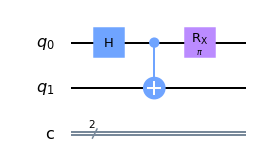

In [9]:
circuit=QuantumCircuit(2,2)
circuit.h(0)
circuit.cx(0, 1)
circuit.rx(np.pi, 0)
circuit.draw('mpl')

# We now implement this ansatz as a python function, Why ? so it can be called upon to use theta as a parameter, as qiskit doesn't allow the RX parameter to be a variable

In [10]:
def ansatz(circuit, theta):
    q = circuit.qregs[0]
    circuit.h(q[0])
    circuit.cx(q[0], q[1])
    circuit.rx(theta, q[0])
    return circuit

# Next we implement a function sets up the measurement in the desired basis, for that wecall the function that implements our ansatz and we then add the unitaries needed to be in the desired basis, we return the quantum circuit necessary for the VQE

In [11]:
def two_qubit_vqe(theta, basis):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # implement the ansate in the circuit
    circuit = ansatz(circuit, theta)
    # measurement
    if basis == 'Z':
        circuit.measure(q, c)
    elif basis == 'X':
        circuit.u2(0, np.pi, q[0])
        circuit.u2(0, np.pi, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif basis == 'Y':
        circuit.u2(0, np.pi/2, q[0])
        circuit.u2(0, np.pi/2, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    else:
        raise ValueError('Not a valid pauli basis, input should be X,Y or Z, we excluded I because no circuit is needed')

    return circuit


# Now we define a function that runs the circuit and calculates the expectation value from the probabilities of each state we measured

In [12]:
def get_expectation(theta, basis):
    
    if basis == 'I':
        return 1
    elif basis == 'Z':
        circuit = two_qubit_vqe(theta, 'Z')
    elif basis == 'X':
        circuit = two_qubit_vqe(theta, 'X')
    elif basis == 'Y':
        circuit = two_qubit_vqe(theta, 'Y')
    else:
        raise ValueError('Not a valid pauli basis, input should be I,X,Y or Z')
    
    shots = 1996 # My birthyear c:
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    expected_value = 0
    for event in counts:
        pm = 1
        if event == '01':
            pm = -1
        if event == '10':
            pm = -1
        expected_value += pm * counts[event] / shots
        
    return expected_value

# Finally we write a function that calls the previous ones, measures runs a circuit for each basis and sums the results times the coefficient that acompanies each term in our hamiltonian for any given value of our variational parameter

In [13]:
def vqe_ground(theta):
        
    ground_I = coeff['II']*get_expectation(theta, 'I')
    ground_Z = coeff['ZZ']*get_expectation(theta, 'Z')
    ground_X = coeff['XX']*get_expectation(theta, 'X')
    ground_Y = coeff['YY']*get_expectation(theta, 'Y')
    
    # summing the measurement results
    sum_ = ground_I+ground_Z+ground_X+ground_Y
    
    return sum_

# Since our ansatz has only one parameter $\theta$ and it can take values from 0 to $2 \pi$, to find the minimum we simply plot the calculated ground state energy, vs the value of $theta$

In [14]:
theta=np.arange(-np.pi,np.pi,np.pi/64)
E_0 = [ vqe_ground(i) for i in theta]


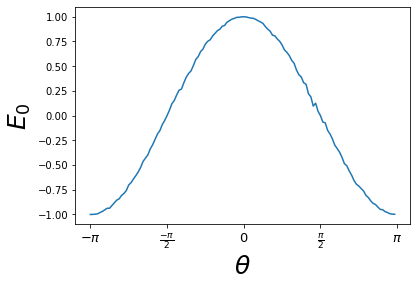

In [15]:
plt.plot(theta,E_0)
plt.xlabel(r'$\theta$',fontsize=25)
plt.ylabel(r'$E_{0}$',fontsize=25)
plt.xticks(np.arange(-np.pi,np.pi+1, step=np.pi/2),[r'$-\pi$',r'$\frac{-\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=13)
plt.show()

# In case $E_{0}$ is not clear from the plot we call the min function on the values we plotted, and compare with the eigenvalues of the matrix

In [17]:
min(E_0)

-1.00000000000000

In [18]:
Matriz.eigenvals()

{-1: 1, 1: 3}